In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [47]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
0,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [48]:
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
data_training.head()

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200


In [49]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data

array([[0.12128111, 0.13341652, 0.10395486, 0.10261801, 1.        ],
       [0.09335154, 0.09178937, 0.07853803, 0.08159383, 0.28587298],
       [0.07351751, 0.07646618, 0.06806629, 0.06642639, 0.16889149],
       ...,
       [0.63180528, 0.63104567, 0.6289142 , 0.63322819, 0.02870152],
       [0.63246307, 0.6303469 , 0.62672831, 0.63307803, 0.01798936],
       [0.63281721, 0.63433992, 0.63552259, 0.63107575, 0.01232227]])

In [50]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

In [51]:
model = keras.models.Sequential([
    # 50 nodes comming out, return sequences means returns the data as it enters
    # input shape entering is window, result (60, 5) -> five data all the table
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 5)),
    # Drop 20% random -> regularization to avoid exploding gradient
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.4),
    # the last one never must have return sequences true, bc you dont want your input to be the output
    # you want only a result
    keras.layers.LSTM(units=120, activation='relu'),
    keras.layers.Dropout(0.5),
    # output layer, dense layer, return one result -> units
    keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 80)            27520     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 80)            51520     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            51520     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)              

In [52]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


2021-11-15 16:52:02.188123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 643s 13s/step - loss: 0.0469
Epoch 2/100
51/51 [==============================] - 648s 13s/step - loss: 0.0097
Epoch 3/100
51/51 [==============================] - 658s 13s/step - loss: 0.0083
Epoch 4/100
51/51 [==============================] - 638s 13s/step - loss: 0.0063
Epoch 5/100
51/51 [==============================] - 613s 12s/step - loss: 0.0061
Epoch 6/100
51/51 [==============================] - 612s 12s/step - loss: 0.0065
Epoch 7/100
51/51 [==============================] - 613s 12s/step - loss: 0.0069
Epoch 8/100
51/51 [==============================] - 613s 12s/step - loss: 0.0058
Epoch 9/100
51/51 [==============================] - 614s 12s/step - loss: 0.0056
Epoch 10/100
51/51 [==============================] - 612s 12s/step - loss: 0.0054
Epoch 11/100
51/51 [==============================] - 612s 12s/step - loss: 0.0055
Epoch 12/100
51/51 [==============================] - 611s 12s/step - loss: 0.0052
Epoch 13/100
51/51 [=====

Epoch 100/100
51/51 [==============================] - 641s 13s/step - loss: 0.0023


In [61]:
data_test.head()

,Open,High,Low,Close,Volume
1673,142.000000,146.570007,141.270004,145.389999,20520300
1674,146.009995,150.679993,145.990005,148.949997,24069000
1675,149.000000,149.649994,147.000000,147.539993,18025700
1676,146.949997,149.000000,146.500000,148.300003,15787900
1677,149.750000,152.429993,148.550003,150.039993,31029600


In [62]:
past_window_days = data_training.tail(window)
# get window size of previous data to continue from the training data to the test data
# that way we put a link between test and time line data

df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
772,340.000000,341.309998,334.470001,335.369995,17556700
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200


In [63]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction
inputs

array([[0.69479859, 0.7047168 , 0.69875962, 0.70606197, 0.02337125],
       [0.71584698, 0.70985779, 0.71370473, 0.70926565, 0.02057364],
       [0.71053427, 0.70072377, 0.68996541, 0.68673974, 0.02776646],
       ...,
       [1.57731231, 1.56820564, 1.57304795, 1.55183456, 0.01138615],
       [1.57913373, 1.6151235 , 1.5871797 , 1.61766038, 0.03430572],
       [1.65077917, 1.67397056, 1.65539856, 1.65304348, 0.0258928 ]])

In [64]:
x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((717, 60, 5), (717,))

In [65]:
y_pred = model.predict(x_test)
y_pred

array([[0.5820205 ],
       [0.5903059 ],
       [0.597859  ],
       [0.60498136],
       [0.6116717 ],
       [0.61735225],
       [0.62187284],
       [0.62482536],
       [0.6258503 ],
       [0.6258364 ],
       [0.62591976],
       [0.6261761 ],
       [0.6253731 ],
       [0.6248815 ],
       [0.62794244],
       [0.636266  ],
       [0.64954674],
       [0.6663829 ],
       [0.68332404],
       [0.6977616 ],
       [0.70878637],
       [0.71602   ],
       [0.7198299 ],
       [0.7209135 ],
       [0.7199367 ],
       [0.71753776],
       [0.7148036 ],
       [0.71196294],
       [0.7092753 ],
       [0.70743215],
       [0.70723045],
       [0.7081022 ],
       [0.70936847],
       [0.7106108 ],
       [0.71175504],
       [0.71297574],
       [0.715546  ],
       [0.71934533],
       [0.72348195],
       [0.7279558 ],
       [0.73291934],
       [0.7381712 ],
       [0.74189425],
       [0.74132395],
       [0.73576504],
       [0.7273282 ],
       [0.7188209 ],
       [0.712

In [66]:
# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

(array([5.05970448e-03, 4.99126542e-03, 5.08336709e-03, 5.00575661e-03,
        1.76160763e-09]),
 0.00505970448005251,
 197.64000129699707)

In [67]:
y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales
y_test_final

array([123.92000008, 127.92999458, 130.92000008, 128.86999702,
       131.67000008, 131.11999702, 130.19999886, 126.55999947,
       129.3999958 , 129.97000313, 130.00999641, 128.1400013 ,
       147.52000618, 147.75999641, 147.61999702, 151.06999397,
       153.11999702, 150.11999702, 146.3900013 , 149.81999397,
       148.78000069, 147.30000496, 145.11000252, 146.42999458,
       142.42000008, 144.17000008, 143.84999275, 142.50000191,
       144.9900074 , 146.25999641, 144.81999397, 144.28999519,
       144.52000618, 145.81999397, 149.28999519, 154.81999397,
       153.42000008, 148.11999702, 153.52000618, 154.00999641,
       154.2400074 , 151.67999458, 149.08000374, 145.4900074 ,
       143.3999958 , 143.42000008, 146.80999947, 147.56999397,
       144.92000008, 149.27000618, 149.77000618, 146.4900074 ,
       148.30999947, 149.75000191, 152.05999947, 156.42000008,
       157.94000435, 158.80000496, 157.13000679, 157.53999519,
       160.09999275, 160.16000557, 159.92000008, 160.42

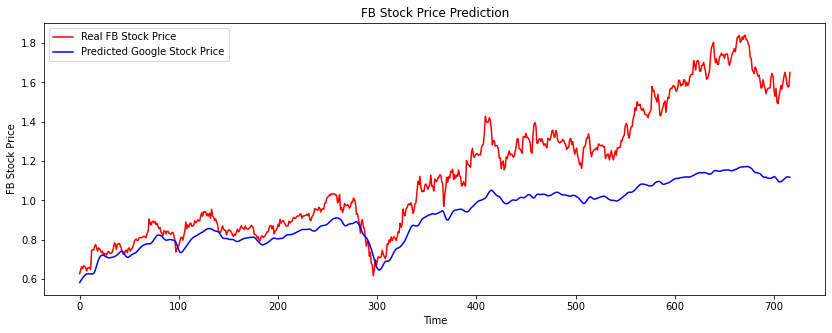

In [68]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted Google Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()